## Dependencies

In [1]:
import json, warnings, shutil, glob, time
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 
                                                   'attention_mask': x_train[1]}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 
                                                   'attention_mask': x_valid[1]}, y_valid))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 
                                                  'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
print('Validation samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-1/fold_5.tar.gz

Train samples: 267220
Validation samples: 8000


,index,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,894207,@Little Jimmy: I agree. I would also suggest t...,0.00000,0,train,train,validation,train,train
1,1681221,Well. There is already soft enforcement. Ho...,0.00000,0,train,train,validation,train,train
2,1320527,Great another mediocre season.,0.60000,1,train,train,validation,train,train
3,1521370,Putting your money where your mouth is. Can't...,0.65625,1,validation,train,train,train,train
4,922924,Despite the eloquence of your (non-)response (...,0.00000,0,train,train,train,train,validation


fold_1/
fold_1/y_valid.npy
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy


# Model parameters

In [5]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 5,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _= base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').reshape(x_train.shape[1], 1).astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)
    
    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y, probabilities)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_accuracy.update_state(y, probabilities)
            train_auc.update_state(y, probabilities)
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y, probabilities)
            valid_accuracy.update_state(y, probabilities)
            valid_auc.update_state(y, probabilities)
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))
    
    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        optimizer = optimizers.Adam(lr=config['LEARNING_RATE'])
        loss_fn = losses.binary_crossentropy

        train_accuracy = metrics.BinaryAccuracy()
        valid_accuracy = metrics.BinaryAccuracy()
        train_auc = metrics.AUC()
        valid_auc = metrics.AUC()
        train_loss = metrics.Sum()
        valid_loss = metrics.Sum()
        
    # Setup training loop
    step = 0
    epoch = 0
    epoch_steps = 0
    epoch_start_time = time.time()
    history = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': [], 
               'accuracy': [], 'val_accuracy': []}
    patience_cnt = 0
    best_val = float("inf")

    ### Train model
    while True:
        train_step(train_data_iter)
        epoch_steps += step_size
        step += step_size

        # validation run at the end of each epoch
        if (step // step_size) > epoch:
            # validation run
            valid_epoch_steps = 0
            valid_step(valid_data_iter)
            valid_epoch_steps += valid_step_size

            # compute metrics
            history['accuracy'].append(train_accuracy.result().numpy())
            history['auc'].append(train_auc.result().numpy())
            history['loss'].append(train_loss.result().numpy() / (config['BATCH_SIZE'] * epoch_steps))
            history['val_accuracy'].append(valid_accuracy.result().numpy())
            history['val_auc'].append(valid_auc.result().numpy())
            history['val_loss'].append(valid_loss.result().numpy() / (config['BATCH_SIZE'] * valid_epoch_steps))

            # report metrics
            epoch_time = time.time() - epoch_start_time
            print('\nEPOCH {:d}/{:d}'.format(epoch+1, config['EPOCHS']))
            print('time: {:0.1f}s'.format(epoch_time),
                  'loss: {:0.4f}'.format(history['loss'][-1]),
                  'auc: {:0.4f}'.format(history['auc'][-1]),
                  'accuracy: {:0.4f}'.format(history['accuracy'][-1]),
                  'val_loss: {:0.4f}'.format(history['val_loss'][-1]),
                  'val_auc: {:0.4f}'.format(history['val_auc'][-1]),
                  'val_accuracy: {:0.4f}'.format(history['val_accuracy'][-1]))

            # set up next epoch
            epoch = step // step_size
            epoch_steps = 0
            epoch_start_time = time.time()
            train_accuracy.reset_states()
            train_auc.reset_states()
            train_loss.reset_states()
            valid_accuracy.reset_states()
            valid_auc.reset_states()
            valid_loss.reset_states()

            # Early stopping monitor
            if history['val_loss'][-1] <= best_val:
                best_val = history['val_loss'][-1]
                model.save_weights(model_path)
                print('Saved model weights at "%s"' % model_path)
            else:
                patience_cnt += 1
            if patience_cnt > config['ES_PATIENCE']:
                print('Epoch %05d: early stopping' % epoch)
                break
                
            if epoch >= config['EPOCHS']:
                model.save_weights(model_path)
                print('Training finished saved model weights at "%s"' % model_path)
                break
        
    history_list.append(history)
    
#     # Fine-tune on validation set
#     print('\nFine-tune on validation set')
#     n_steps2 = x_valid_ml.shape[1] // config['BATCH_SIZE']

#     history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
#                          steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
#                          verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
    valid_ml_preds = model.predict(get_test_dataset(x_valid_ml, config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
    valid_df['pred_%d' % (n_fold+1)] = valid_ml_preds


FOLD: 1

EPOCH 1/5
time: 704.3s loss: 0.4148 auc: 0.9427 accuracy: 0.4706 val_loss: 0.2513 val_auc: 0.9228 val_accuracy: 0.8713
Saved model weights at "model_fold_1.h5"

EPOCH 2/5
time: 521.9s loss: 0.3833 auc: 0.9568 accuracy: 0.4787 val_loss: 0.2523 val_auc: 0.9260 val_accuracy: 0.8691

EPOCH 3/5
time: 512.6s loss: 0.3725 auc: 0.9615 accuracy: 0.4821 val_loss: 0.2800 val_auc: 0.9133 val_accuracy: 0.8620
Epoch 00003: early stopping


## Model loss graph

Fold: 1


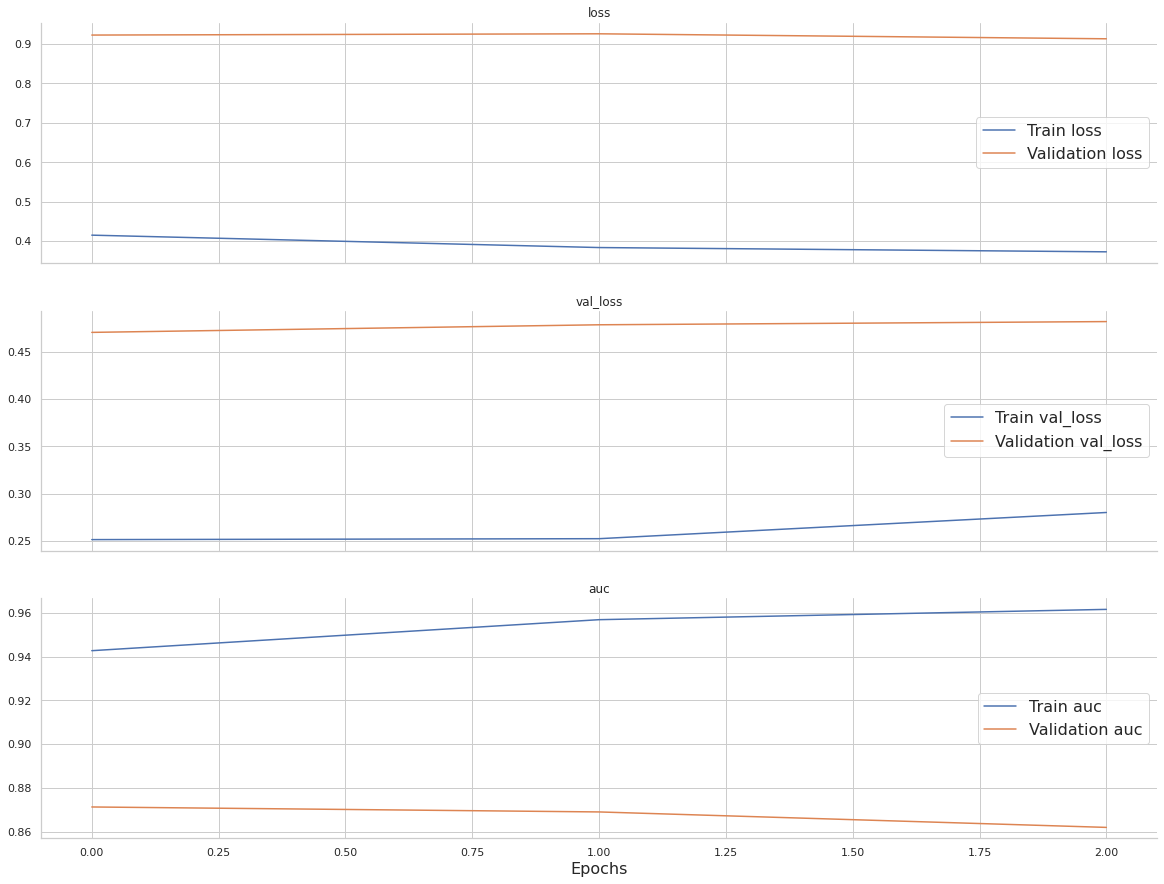

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.918493,0.918493
es,0.896556,0.896556
it,0.881504,0.881504
tr,0.98175,0.98175


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,@Little Jimmy: I agree. I would also suggest that shareholder expectations about returns are sometimes what give the...,0.00000
1,Well. There is already soft enforcement. How many places won't let you comment without Facebook?,0.00000
2,Great another mediocre season.,0.60000
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no prob...",0.65625
4,"Despite the eloquence of your (non-)response (he said, sarcastically), a large and growing majority of Americans thi...",0.00000
5,Are you saying the majority of people in cities across the country with rail transit want their systems shut down? C...,0.00000
6,What about Junior's vacation investigation; Morneau and his conflicts of interest; Junior's and Morneau's hidden mo...,0.60000
7,Here's a great article that describes what happened in Chicago when they sold their parking authority to a Wall Stre...,0.20000
8,"scuppers.. Facts and reality won't help your case. You'll need to get into the gutter with false facts, false accusa...",1.00000
9,Clearly those people haven't seen the latest Jack Reacher movie for proper instructions on beating up on bad guys.\n...,0.00000


Multilingual validation set


,comment_text,toxic,pred_1
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.838319
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.004082
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.785321
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.001402
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.000447
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.001238
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.000936
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.000290
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.000649
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.005136


# Test set predictions

In [13]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.237072
std,18421.082026,0.311080
min,0.000000,0.000247
25%,15952.750000,0.002880
50%,31905.500000,0.020561
75%,47858.250000,0.502466
max,63811.000000,0.999707


,id,toxic
0,0,0.002047
1,1,0.005304
2,2,0.349549
3,3,0.002603
4,4,0.001931
5,5,0.019367
6,6,0.001241
7,7,0.008812
8,8,0.795380
9,9,0.131405
